In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Add the python path to the folder containing some useful custom packages.
import sys
sys.path.insert(0, "../../packages/")
from TsIP.TsIP import TsIP
from tools import find_multiple_sets
from LagsCreator.LagsCreator import LagsCreator

## Dataset

In [3]:
COUNTRY = "Yemen"

In [4]:
PATH_TO_DATA_FOLDER = "../../Dataset time-series/data/" + COUNTRY + "/"

In [5]:
# Load the dataset of the training sets.
train = pd.read_csv(PATH_TO_DATA_FOLDER + "train_smooth.csv", header = [0, 1], index_col = 0)
train.index.name = "Datetime"
train.index = pd.to_datetime(train.index)
freq = "D"
train.index.freq = freq

In [6]:
# Load the dataset of the test sets.
test = pd.read_csv(PATH_TO_DATA_FOLDER + "test_target.csv", header = [0, 1], index_col = 0)
test.index.name = "Datetime"
test.index = pd.to_datetime(test.index)
freq = "D"
test.index.freq = freq

In [7]:
# Load the dataset of the whole time-series of the fcs indicator.
target = pd.read_csv(PATH_TO_DATA_FOLDER + "all_target.csv", header = [0, 1], index_col = 0)
target.index.name = "Datetime"
target.index = pd.to_datetime(target.index)
freq = "D"
target.index.freq = freq

In [8]:
TEST_SIZE = 30
FREQ = train.index.freq

In [9]:
TRAIN = train.copy()

In [10]:
PROVINCES = TRAIN.columns.get_level_values(0).unique()
PROVINCES

Index(['Abyan', 'Aden', 'Al Bayda', 'Al Dhale'e', 'Al Hudaydah', 'Al Jawf',
       'Al Maharah', 'Al Mahwit', 'Amanat Al Asimah', 'Amran', 'Dhamar',
       'Hajjah', 'Ibb', 'Lahj', 'Marib', 'Raymah', 'Sa'ada', 'Sana'a',
       'Shabwah', 'Taizz'],
      dtype='object', name='AdminStrata')

In [11]:
PREDICTORS = TRAIN.columns.get_level_values(1).unique()
PREDICTORS

Index(['1 Month Anomaly (%) Rainfall', '3 Months Anomaly (%) Rainfall',
       'Cereals and tubers', 'Exchange rate (USD/LCU)', 'FCS', 'Fatality',
       'Lat', 'Lon', 'NDVI Anomaly', 'Population', 'Rainfall (mm)', 'Ramadan',
       'rCSI'],
      dtype='object', name='Indicator')

## Data source transformation

I decide to normalize the data among the provinces considering indicator by indicator and considering only the training sets.

In [12]:
global SCALERS

MIN = 0
MAX = 1
SCALERS = dict()
def normalization(group, feature_range):
    min_, max_ = feature_range
    min_group = group.min().min()
    max_group = group.max().max()
    
    # Normalization.
    group_std = (group - min_group) / (max_group - min_group)
    group_scaled = group_std * (max_ - min_) + min_

    # Save the scalers for the various indicators.
    SCALERS[group.name] = (min_group, max_group)

    return group_scaled

In [13]:
TRAIN_NORMALIZED = TRAIN.groupby(axis = 1, level = 1).apply(lambda x: normalization(x, (MIN, MAX)))
TRAIN_NORMALIZED.head()

AdminStrata                        Abyan                                \
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2018-08-22                      0.202614                      0.327464   
2018-08-23                      0.201694                      0.323172   
2018-08-24                      0.200218                      0.317813   
2018-08-25                      0.198491                      0.312132   
2018-08-26                      0.196724                      0.306528   

AdminStrata                                                                 \
Indicator   Cereals and tubers Exchange rate (USD/LCU)       FCS  Fatality   
Datetime                                                                     
2018-08-22            0.109379                0.097113  0.398119  0.016014   
2018-08-23            0.115215                0.108255  0.416745  0.014270   
2018-08-24            0.118301                0.112477  0.422543  0.014297   
2018-08-25            0.119918                0.113002  0.424258  0.015185   
2018-08-26            0.121119                0.112481  0.427209  0.016327   

AdminStrata                                              ...  \
Indicator         Lat       Lon NDVI Anomaly Population  ...   
Datetime                                                 ...   
2018-08-22   0.204339  0.354998     0.203677   0.137715  ...   
2018-08-23   0.204339  0.354998     0.201767   0.137715  ...   
2018-08-24   0.204339  0.354998     0.199870   0.137715  ...   
2018-08-25   0.204339  0.354998     0.197950   0.137715  ...   
2018-08-26   0.204339  0.354998     0.195990   0.137715  ...   

AdminStrata                   Taizz                                        \
Indicator   Exchange rate (USD/LCU)       FCS  Fatality      Lat      Lon   
Datetime                                                                    
2018-08-22                 0.100691  0.521481  0.124455  0.13656  0.07253   
2018-08-23                 0.105181  0.505624  0.118668  0.13656  0.07253   
2018-08-24                 0.109271  0.494372  0.115789  0.13656  0.07253   
2018-08-25                 0.113148  0.486382  0.115893  0.13656  0.07253   
2018-08-26                 0.116965  0.480822  0.118913  0.13656  0.07253   

AdminStrata                                                          
Indicator   NDVI Anomaly Population Rainfall (mm) Ramadan      rCSI  
Datetime                                                             
2018-08-22      0.317287   0.894478      0.430215     0.0  0.522625  
2018-08-23      0.314277   0.894478      0.436639     0.0  0.513277  
2018-08-24      0.311164   0.894478      0.446466     0.0  0.511028  
2018-08-25      0.307901   0.894478      0.458051     0.0  0.511425  
2018-08-26      0.304470   0.894478      0.470108     0.0  0.512072  

[5 rows x 260 columns]

In [14]:
# Plot time-series.
#TsIP(TRAIN_NORMALIZED).interactive_plot_df(title = "Training sets", matplotlib = False, style = "lines")

In [15]:
def denormalization(group_scaled, indicator, feature_range, scalers):
    min_, max_ = feature_range
    min_group, max_group = scalers[indicator]

    group_std = (group_scaled - min_) / (max_ - min_)
    group = (group_std * (max_group - min_group)) + min_group
    
    return group

In [16]:
# Get the training and test sets.
TRAIN_NORMALIZED_SETS = find_multiple_sets(TRAIN_NORMALIZED)
TEST_TARGET_SETS = find_multiple_sets(test)

## Training

In [49]:
LAGS = 14

In [50]:
lags_dict = dict()
# Define lags for each indicator.
lags_dict["3 Months Anomaly (%) Rainfall"] = LAGS
lags_dict["1 Month Anomaly (%) Rainfall"] = LAGS
lags_dict["Cereals and tubers"] = LAGS
lags_dict["Exchange rate (USD/LCU)"] = LAGS
lags_dict["FCS"] = LAGS
lags_dict["Fatality"] = LAGS
lags_dict["NDVI Anomaly"] = LAGS
lags_dict["Rainfall (mm)"] = LAGS
lags_dict["rCSI"] = LAGS
lags_dict["Lat"] = 0
lags_dict["Lon"] = 0
lags_dict["Population"] = 0
lags_dict["Ramadan"] = LAGS

In [51]:
from sklearn.svm import SVR

In [52]:
FORECASTING_NORMALIZED = test.copy()

In [53]:
for h in range(TEST_SIZE):
    X_train_list, y_train_list = list(), list()
    X_test_dict = dict()
    for i, train_normalized in enumerate(TRAIN_NORMALIZED_SETS):
        for PROVINCE in PROVINCES:
            creator = LagsCreator(train_normalized[[PROVINCE]], lags_dictionary = lags_dict, target = "FCS")
            X_train, y_train, _, _, X_test = creator.to_supervised(n_out = TEST_SIZE, single_step = True, h = h+1, return_dataframe = True,
                                                                   feature_time = False, validation = False, return_single_level = True, 
                                                                   dtype = np.float32)
            # Add a list of all the training samples of all the provinces together.
            X_train_list.append(X_train)
            y_train_list.append(y_train)
            
            # Add the test sample of the province of the current set into a dictionary.
            X_test_dict[(PROVINCE, i)] = X_test

    X_train = pd.concat(X_train_list).values
    y_train = pd.concat(y_train_list).values.flatten()

    print("Training %s samples for the prediction horizon h: %d" % (str(X_train.shape), h+1), end = "\r")
    model = SVR(gamma = "auto")
    model.fit(X_train, y_train)  

    # Prediction.
    for i, test_set in enumerate(TEST_TARGET_SETS):
        for PROVINCE in PROVINCES:
            X_test = X_test_dict[(PROVINCE, i)].values
            y_hat = model.predict(X_test)[0]
            FORECASTING_NORMALIZED[(PROVINCE, "FCS")].loc[test_set.index[h]] = y_hat

In [54]:
# Denormalization.
FORECASTING = denormalization(FORECASTING_NORMALIZED, "FCS", (MIN, MAX), SCALERS)

In [55]:
# Plot time-series.
TsIP(FORECASTING, target).interactive_plot_df(title = "Forecasting", matplotlib = False, style = "lines", comparison = True)

interactive(children=(RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Ti…

In [56]:
FORECASTING_TARGET_SETS = find_multiple_sets(FORECASTING)

In [57]:
from sklearn.metrics import mean_squared_error

# Loss.
losses = list()
losses_h = list()
for test_set, forecasting_set in zip(TEST_TARGET_SETS, FORECASTING_TARGET_SETS):
    loss = mean_squared_error(test_set, forecasting_set)
    losses.append(loss)
    loss_h = mean_squared_error(test_set.transpose(), forecasting_set.transpose(), multioutput = "raw_values")    
    losses_h.append(loss_h)

In [58]:
np.mean(losses)

21.606123834327054

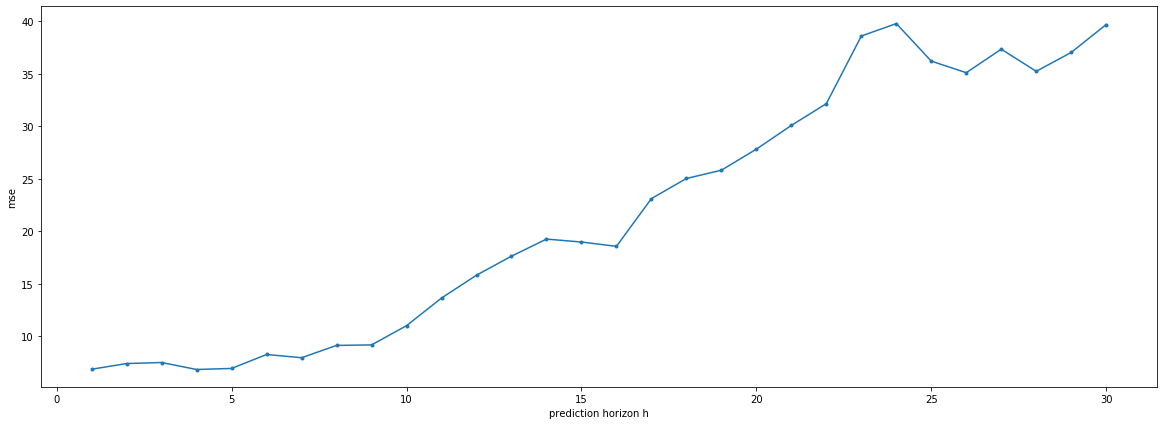

In [59]:
fig, ax = plt.subplots(figsize = (20, 7))
ax.plot(np.arange(1, TEST_SIZE + 1), np.mean(losses_h, axis = 0), ".-")
ax.set_ylabel("mse", fontsize = 10)
ax.set_xlabel("prediction horizon h", fontsize = 10);